# $P_{eff}$ fitting to two-compartment plasma PK

Form of bi-exponential plasma PK equation:

$$ C_V = C_0(\beta e^{-K_1 t}+(1-\beta)e^{-K_2 t}) $$

Form of equation for tumor accumulation: 
$$ C_T = \frac{APC_0\alpha}{1-H} \biggl(\gamma_1 e^{-K_1 t} + \gamma_2 e^{-K_2 t}- \biggl(\gamma_1+\gamma_2\biggr)e^{\frac{-AP}{\alpha V_T}t}\biggr ) $$
$$ \gamma_1 = \frac{\beta}{AP-K_1 V_T \alpha} $$ 
$$ \gamma_2 = \frac{1-\beta}{AP - K_2 V_T \alpha} $$

### NOTE: This code is meant to be used with template worksheets!
Two separate Excel files will be used here: one for storing PK data, and one for storing tumor accumulation data.

Excel file formatting templates are provided on GitHub

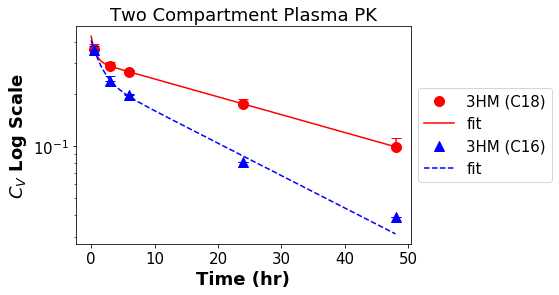

        3HM (C18)    3HM (C16)
----  -----------  -----------
C0      0.430421     0.407854
beta    0.281397     0.397447
K1      1.50796      0.640808
K2      0.0237371    0.0430696
R^2     0.999997     0.998278

Standard deviations:
        3HM (C18)    3HM (C16)
----  -----------  -----------
C0    0.0100995     0.0295188
beta  0.0159962     0.057227
K1    0.172918      0.384642
K2    8.54977e-05   0.00680831



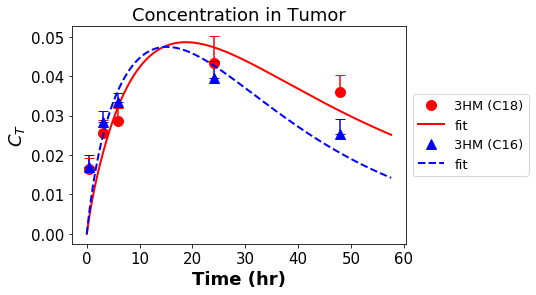

         3HM (C18)    3HM (C16)
-----  -----------  -----------
alpha     0.147158     0.222045
beta      0.281397     0.397447
Peff      1.45034      1.86288
SD        0.41845      0.401891
%SD      28.8518      21.5736


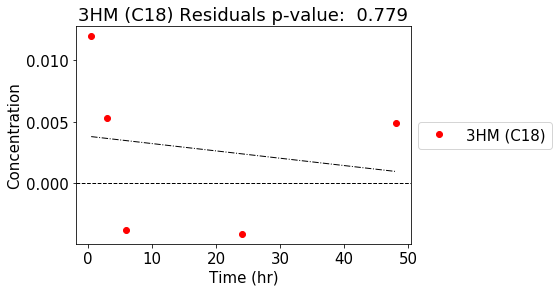

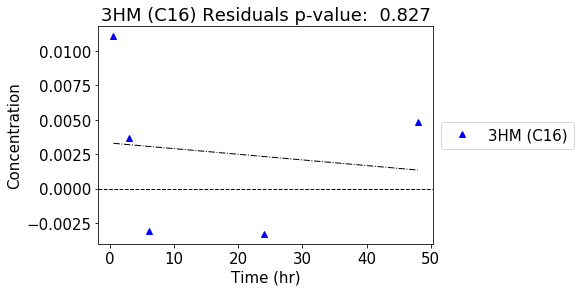

In [20]:
# Original code created by Marc Lim, Ting Xu Lab, UC Berkeley, February 2020
# Xu Lab website: https://xugroup.berkeley.edu/ 

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as fitter
%matplotlib inline


#   IMPORTING VALUES FROM WORKBOOK

from openpyxl import load_workbook

# Put relative filepath to PK data excel file here
book = load_workbook(' filepath/filename1.xlsx ')   # REPLACE "filepath/filename1.xlsx" with the right directory
                                                       # example: C:/Users/John/PK_data.xlsx
sheetNames = book.sheetnames

# Put relative filepath to Tumor data excel file here
book2 = load_workbook(' filepath/filename2.xlsx ')  # REPLACE "filepath/filename2.xlsx" with the right directory
                                                        # example: C:/Users/John/TUMOR_data.xlsx
sheetNames2 = book2.sheetnames

# Enter index of sheet you want analyzed
worksheet1 = book[sheetNames[0]]    #want the first sheet of this PK data excel file
colA = worksheet1['A']

worksheet2 = book2[sheetNames2[0]]    #want the first sheet of this Tumor data excel file
colA2 = worksheet2['A']


#   PK PROFILE FITS
   
#   GET SERIES TITLES

titlerow = 1       #titles are on Row 1
titleArr = []
counter1 = 0
for colNum in range(1,50):
    colLetter = chr(colNum+65)   #series title is in Excel column B onwards
    col = worksheet1[colLetter];
    if col[titlerow-1].value==None:    #stop loop when reach a column without any values
        break
    titleArr.append(col[titlerow-1].value)
    counter1 = counter1 + 1
#print("Series: ",titleArr)


#   GET ALL TIME VALUES

timerow = 3      #data are in Row 3
PKtimeArr  = []
for i in range(timerow-1, 50):    #get timepoints stored in colA[2] = Excel row 3, onwards
    if colA[i].value==None:     #stop loop when reach a row without any values. Excel data MUST BE "Number" type
        break
    PKtimeArr.append(colA[i].value)    #data now stored all in one row in xdata array 
#print("PK time arrays: ",PKtimeArr)
    
    
#   GET CONCENTRATION VALUES

datarow = 3      #data are in Row 3
PKconcArr = [[0 for height in  range(len(PKtimeArr))] for width in range(len(titleArr))]   
          #empty 2D array with width of titles (i.e. number of lists) and height of timepoints (number of items / list)
counter = 0
for colNum in range(1,len(titleArr)+1):   #cycle through data in each Excel column
    colLetter = chr(colNum+65)            #chr(65) is A, and data is stored in columns B onwards (hence colNum + 65)
    col = worksheet1[colLetter];          #select column in worksheet
    i = 0                                 #index for rows inside PKconc column list
    for j in range(datarow-1,datarow+len(PKtimeArr)):     #extract data from current worksheet column 'col'  
        if col[j].value == None:            #stop if no data value found in current row 'j'
            break
        #fill 'y' array row[counter] column[i] with value from current Excel column & row[j]
        PKconcArr[counter][i] = col[j].value;  #fill value from worksheet column'col' row'j' into PKconc column'counter' row'i'
        i = i + 1                      #cycle to next PKconc row'i' before loop moves to next worksheet row'j'   
    counter = counter + 1              #cycle to next PKconc column'counter' before loop moves to next worksheet column
#print("PK concentration arrays: ",PKconcArr)

#   GET ERROR BARS FOR PK DATA

datarowErr = 20      #data are in Row 20
PKErrArr = [[0 for height in  range(len(PKtimeArr))] for width in range(len(titleArr))]   
          # empty 2D array with width of titles (i.e. number of lists) and height of timepoints (number of items / list)
counter = 0
for colNum in range(1,len(titleArr)+1):   #cycle through data in each Excel column
    colLetter = chr(colNum+65)            #chr(65) is A, and data is stored in columns B onwards (hence colNum + 65)
    col = worksheet1[colLetter];          #select column in worksheet
    i = 0                                 #index for rows inside PKconc column list
    for j in range(datarowErr-1,datarowErr+len(PKtimeArr)):     #extract data from current worksheet column 'col'  
        if col[j].value == None:            #stop if no data value found in current row 'j'. Excel data MUST BE "Number" type
            break
        # fill 'y' array row[counter] column[i] with value from current Excel column & row[j]
        PKErrArr[counter][i] = col[j].value;  #fill value from worksheet column'col' row'j' into TUMconc column'counter' row'i'
        i = i + 1                      #cycle to next TUMconc row'i' before loop moves to next worksheet row'j'   
    counter = counter + 1              #cycle to next TUMconc column'counter' before loop moves to next worksheet column
#print("PK error arrays: ",PKErrArr)


#   SETTING UP EQUATIONS

def model_bi_PK (x,C1,b1,a1,a2):   #function to fit particle vessel conc. with bi-exponential PK. x=time, b1=beta, a1=K1, a2=K2
    Cv = C1*(b1*np.exp(-a1*x)+(1-b1)*np.exp(-a2*x))
    return Cv


def Rsquared(q):    #function for coefficient of determination R^2
    xdata = PKtime
    ydata = PKconc
    ysum = fsum = fysum = y2sum = f2sum = 0
    for i in range (0,q):
        ysum += ydata[i]
        fsum += model_bi_PK(xdata[i],C0,beta,K1,K2)
        fysum += ydata[i]*model_bi_PK(xdata[i],C0,beta,K1,K2)
        y2sum += (ydata[i])**2
        f2sum += (model_bi_PK(xdata[i],C0,beta,K1,K2))**2  
    numer = q*fysum-ysum*fsum
    denom = np.sqrt((q*y2sum-(ysum)**2)*(q*f2sum-(fsum)**2))
    R2 = (numer/denom)**2
    return R2


#   SOLVING FIT
    
# Make lists to store values for solutions of each data series
C0Arr = []
C0errArr =[] 
betaArr = []
betaerrArr =[] 
K1Arr = []
K1errArr =[] 
K2Arr = []
K2errArr = []
R2PK = []

# Styles for plot markers and lines
colors = ['red','blue','black','green','magenta','cyan','tab:orange','tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
lines = ['solid','dashed','dotted','dashdot',(0,(5,5)),(0,(3,1,1,1)),'solid','dotted','dashed','dashdot',(0,(5,5)),(0,(3,1,1,1))]
markers = ['o','^','s','*','v','d','p','+','v','X','|']


for j in range(0,len(titleArr)):  #solve fit and plot results for each column

    PKtime = PKtimeArr    
    PKconc = PKconcArr[j]                                           

    parPK,covPK = fitter.curve_fit(model_bi_PK,PKtime,PKconc,p0=([1.0,0.5,1.0,0.01]),
                                           bounds=([0.,0.,0.,0.],[10*PKconcArr[0][0],1.,100,100]))  
    #"par" is the optimal value of the unknown parameters
    #"cov" is the estimated covariance of "par". Array diagonals are the variance.

    perrPK = np.sqrt(np.diag(covPK)) #square root variance to get standard deviation
          
    C0Arr.append(parPK[0])
    C0errArr.append(perrPK[0])
    betaArr.append(parPK[1])
    betaerrArr.append(perrPK[1])
    K1Arr.append(parPK[2])
    K1errArr.append(perrPK[2])
    K2Arr.append(parPK[3])
    K2errArr.append(perrPK[3])
    
    C0 = C0Arr[j]
    C0err = C0errArr[j]
    beta = betaArr[j]
    betaerr = betaerrArr[j] 
    K1 = K1Arr[j]
    K1err = K1errArr[j] 
    K2 = K2Arr[j]
    K2err = K2errArr[j]

    PKxfit = np.linspace(0,PKtime[len(PKtimeArr)-1],500)
    R2PK.append(Rsquared(len(PKtime)))
    #print('R^2 = ',Rsquared(len(PKtime)))

    #   PLOTTING RESULTS

    plt.rcParams.update({'font.size': 15})

    fig1 = plt.figure(1)

    plt.title('Two Compartment Plasma PK')
    plt.plot(PKtime,PKconc,marker=markers[j],color=colors[j],linestyle=' ',markersize = 10,label=titleArr[j])
    plt.plot(PKxfit,model_bi_PK(PKxfit,C0,beta,K1,K2),linestyle=lines[j],color=colors[j],label="fit")
    plt.errorbar(PKtime,PKconc,yerr=(np.zeros(np.size(PKconc)),PKErrArr[j]),ecolor = colors[j],capsize = 5,linestyle=' ')
    axes = plt.gca()

    plt.yscale('log')
    plt.legend(loc='center left',fontsize = 15, bbox_to_anchor=(1, 0.5))     #puts legend box outside plot
    plt.xlabel('Time (hr)',fontsize = 18,fontweight='bold')
    plt.ylabel('$C_{V}$ Log Scale',fontsize = 18,fontweight='bold')

# Save PK profile figure

fig1.savefig('Fig-PK.png', dpi=300, bbox_inches='tight')
plt.show()

# Save all variables in table format
    
from tabulate import tabulate
rowIDs = ["C0","beta","K1","K2","R^2"]
rowIDs2 = ["C0","beta","K1","K2"]
PK_output = tabulate([C0Arr, betaArr,K1Arr,K2Arr,R2PK], headers=titleArr,showindex=rowIDs)
PK_err_output = tabulate([C0errArr, betaerrArr,K1errArr,K2errArr], headers=titleArr,showindex=rowIDs2)
           
print(PK_output)
print()
print('Standard deviations:')
print(PK_err_output)
print() 
    
text_file=open("PK_output.csv","w")
text_file.write(PK_output)
text_file=open("PK_output_StdDev.csv","w")
text_file.write(PK_err_output)
#text_file.write(PK_err_output)
text_file.close()


#   TUMOR ACCUMULATION FIT
   
#   GET SERIES TITLES

titlerow2 = 1       #titles are on Row 1
titleArr2 = []
for colNum in range(1,50):
    colLetter = chr(colNum+65)   #series title is in Excel column B onwards
    col = worksheet2[colLetter];
    if col[titlerow2-1].value==None:    #stop loop when reach a column without any values
        break
    titleArr2.append(col[titlerow2-1].value)
#print("Tumor Series: ", titleArr2)


#   GET ALL TIME VALUES

timerow = 3      #data are in Row 3
TUMtimeArr  = []
for i in range(timerow-1, 20):    #get timepoints stored in colA[2] = Excel row 3, onwards
    if colA2[i].value==None:     #stop loop when reach a row without any values
        break
    TUMtimeArr.append(colA2[i].value)    #data now stored all in one row in xdata array 
#print("Tumor time arrays: ",TUMtimeArr)
    
    
#   GET CONCENTRATION VALUES

datarow = 3      #data are in Row 3
TUMconcArr = [[0 for height in  range(len(TUMtimeArr))] for width in range(len(titleArr2))]   
          #empty 2D array with width of titles (i.e. number of lists) and height of timepoints (number of items / list)
counter = 0
for colNum in range(1,len(titleArr2)+1):   #cycle through data in each Excel column
    colLetter = chr(colNum+65)            #chr(65) is A, and data is stored in columns B onwards (hence colNum + 65)
    col = worksheet2[colLetter];          #select column in worksheet
    i = 0                                 #index for rows inside PKconc column list
    for j in range(datarow-1,datarow+len(TUMtimeArr)):     #extract data from current worksheet column 'col'  
        if col[j].value == None:            #stop if no data value found in current row 'j'. Excel data MUST BE "Number" type
            break
        #fill 'y' array row[counter] column[i] with value from current Excel column & row[j]
        TUMconcArr[counter][i] = col[j].value;  #fill value from worksheet column'col' row'j' into TUMconc column'counter' row'i'
        i = i + 1                      #cycle to next TUMconc row'i' before loop moves to next worksheet row'j'   
    counter = counter + 1              #cycle to next TUMconc column'counter' before loop moves to next worksheet column
#print("Tumor concentration arrays: ",TUMconcArr)

#   GET ERROR BARS FOR TUM DATA

datarowErr = 20      #data are in Row 3
TUMErrArr = [[0 for height in  range(len(TUMtimeArr))] for width in range(len(titleArr2))]   
          #empty 2D array with width of titles (i.e. number of lists) and height of timepoints (number of items / list)
counter = 0
for colNum in range(1,len(titleArr2)+1):   #cycle through data in each Excel column
    colLetter = chr(colNum+65)            #chr(65) is A, and data is stored in columns B onwards (hence colNum + 65)
    col = worksheet2[colLetter];          #select column in worksheet
    i = 0                                 #index for rows inside PKconc column list
    for j in range(datarowErr-1,datarowErr+len(TUMtimeArr)):     #extract data from current worksheet column 'col'  
        if col[j].value == None:            #stop if no data value found in current row 'j'. Excel data MUST BE "Number" type
            break
        #fill 'y' array row[counter] column[i] with value from current Excel column & row[j]
        TUMErrArr[counter][i] = col[j].value;  #fill value from worksheet column'col' row'j' into TUMconc column'counter' row'i'
        i = i + 1                      #cycle to next TUMconc row'i' before loop moves to next worksheet row'j'   
    counter = counter + 1              #cycle to next TUMconc column'counter' before loop moves to next worksheet column
#print("Tumor error arrays: ",TUMErrArr)



#   DEFINE MODEL

def fullmodel (x,p,a):   #function to calculate nanoparticle concentration in tumor. "p" is P_eff, "a" is alpha
    A = 1          #flux area set to 1
    V_T = 100      #tumor vol set to 100 um3
    gamma1 = (A*p*C0*a*beta)/((1-H)*(A*p - K1*V_T*a))
    gamma2 = (A*p*C0*a)*(1-beta)/((1-H)*(A*p - K2*V_T*a))
    Ct = gamma1*np.exp(-K1*x)+gamma2*np.exp(-K2*x)-(gamma1+gamma2)*np.exp(-A*p*x/(a*V_T))  
    return Ct


#   SOLVING FIT

PeffArr = []
Peff_errArr = []
Peff_RSD_Arr = []
alphaArr = []

residuals = np.zeros((np.size(titleArr2), np.size(TUMtimeArr)))


for j in range(0,len(titleArr2)):  #solve fit and plot results for each column

    TUMtime = TUMtimeArr    
    TUMconc = TUMconcArr[j]

    H = 0.4     # Hematocrit set to 40%
    
    #Use values from PK fits
    C0 = C0Arr[j]                    
    C0err = C0errArr[j]
    beta = betaArr[j]
    betaerr = betaerrArr[j] 
    K1 = K1Arr[j]
    K1err = K1errArr[j] 
    K2 = K2Arr[j]
    K2err = K2errArr[j]

    par,cov = fitter.curve_fit(fullmodel,TUMtime,TUMconc,p0=([0.1,0.2]),bounds=([0.,0.1],[9999.,0.5]))  
    #"par" is the optimal value of the unknown parameters
    #"cov" is the estimated covariance of "par". Array diagonals are the variance.

    #print(par)
    #print(np.sqrt(cov[0]))
    
    PeffArr.append(par[0])
    Peff_errArr.append(np.sqrt(cov[0][0]))
        
    Peff = PeffArr[j]
    Peff_err = Peff_errArr[j]
    Peff_RSD_Arr.append(100*Peff_err/Peff)
    
    alphaArr.append(par[1])
    alpha = alphaArr[j]

    # Calculate fit residuals
    for i in range(0, len(TUMtime)):
        modely = fullmodel(TUMtime[i],Peff,alpha)
        residuals[j][i] = (TUMconc[i]-modely)   #[j] is the row, [i] is the column
        i = i+1
    #print('Residuals: ',residuals[j])
    
    
    #PLOTTING RESULTS

    #plt.rcParams.update({'font.size': 18})

    fig2 = plt.figure(1)
    TUMxfit = np.linspace(0,TUMtime[len(TUMtime)-1]*1.2,500)

    plt.title('Concentration in Tumor')
    plt.plot(TUMtime,TUMconc,marker=markers[j],color=colors[j],linestyle=' ',markersize = 10, label=titleArr2[j])
    plt.plot(TUMxfit,fullmodel(TUMxfit,Peff,alpha),linestyle=lines[j],color=colors[j],lw = 2,label="fit")
    axes = plt.gca()
    
    plt.errorbar(TUMtime,TUMconc,yerr=(np.zeros(np.size(TUMconc)),TUMErrArr[j]),ecolor = colors[j],capsize = 5,linestyle=' ')
    plt.legend(fontsize = 13,loc='center left', bbox_to_anchor=(1, 0.5))     #puts legend box outside plot
    plt.xlabel('Time (hr)',fontsize = 18,fontweight='bold')
    plt.ylabel('$C_{T}$',fontsize = 18,fontweight='bold')

# Save tumor accumulation plot with DFM fit 

fig2.savefig('Fig-TUM.png', dpi=300, bbox_inches='tight') 
plt.show()

# compile TUM data in table

from tabulate import tabulate
rowIDs3 = ["alpha","beta","Peff","SD","%SD"]
Peff_output = tabulate([alphaArr,betaArr,PeffArr, Peff_errArr,Peff_RSD_Arr], headers=titleArr2,showindex=rowIDs3)
print(Peff_output)
    
text_file=open("Peff_output.csv","w")
text_file.write(Peff_output)
text_file.close()

# PLOT RESIDUALS
    
from statsmodels.regression import linear_model
from statsmodels.api import add_constant

for n in range(0,np.size(titleArr2)):
    x_res = []
    y_res = []
    fig3 = plt.figure(3)
    
    plt.ylabel('Concentration')
    plt.xlabel('Time (hr)')
    plt.plot(TUMtime,residuals[n],marker=markers[n],color=colors[n],linestyle=' ',label=titleArr2[n])
    x_res += [TUMtime]
    y_res += [residuals[n]]
    plt.axhline(0,color='black',linestyle='--',linewidth=1)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))     #puts legend box outside plot

    x_res = np.array(sum(x_res, []))
    y_res = np.array(y_res).flatten()
    X = add_constant(x_res)
    model = linear_model.OLS(y_res, X)
    results = model.fit()

    xmin = np.argmin(x_res)
    xmax = np.argmax(x_res)
    
    # linear regression of residual values
    line_fit = results.predict(X[(xmin, xmax), ])   
    
    # generate plot with p-value on the title
    plt.title('{}'.format(titleArr2[n])+' Residuals p-value: {0:6.3f}'.format(results.pvalues[1]))
    plt.plot(x_res[[xmin, xmax]], line_fit, 'k-', lw=1, linestyle="-.")

    # saves residual plot for each series
    fig3.savefig('Fig-Residuals {}.png'.format(n), dpi=300, bbox_inches='tight')
    plt.show()   
